# Data analysis with pandas: MovieLens 1M dataset

As part of the journey teaching myself the great [pandas](https://pandas.pydata.org/) library, I decided to work on a real publicly available dataset and attempt to analyze it using pandas methods and functionalities. Further, from the very beginning, I decided to use [Jupyter Notebook](http://jupyter.org/) and complement the codes I would write with some rather short explanations of the process of data analysis as well as some brief interpretations of the resutls. So what follows is my attempt at analyzing [MovieLens 1M](http://grouplens.org/datasets/movielens/1m/) dataset which contains around 1 million ratings from 6000 users on 4000 movies and has been released in Februrary 2003 by [GroupLens](https://grouplens.org/). So let's start with the first step which is data loading.

---

## Data Loading

Before everything we need to download MovieLens 1M dataset which is bundled as a [zip file](http://files.grouplens.org/datasets/movielens/ml-1m.zip) and we need to extact its contents. Then, we start by importing all the necessary packages and configuring them as needed:

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap as wrp

sns.set(style="whitegrid")

After downloading and extracting the "ml-1m.zip" file you would find three data files ("movies.dat", "ratings.dat" and "users.dat") which contain the information about movies, users and movie ratings given by users. Also there is an accompanying [README](./ml-1m/README) file which contains general information about the dataset as well as the format of datafiles. We can load the data files in Python using `pandas.read_table` method after consulting the accompanying README file to find out about the format and structure of datafiles. Specifically, in all the tables the entries in each row are separated by `::` (i.e. `sep='::'`) and there is no columns header (i.e. `header=None`), so we explicitly set the columns' names using `names` argument:

In [2]:
dir_path = 'ml-1m' # assuming the files are extracted to a directory named 'ml-1m'

rnames = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings = pd.read_table(os.path.join(dir_path, 'ratings.dat'), 
                        sep='::',
                        header=None,
                        names=rnames,
                        engine='python')

unames = ['UserID', 'Gender', 'Age', 'Occupation', 'Zipcode']
users = pd.read_table(os.path.join(dir_path, 'users.dat'),
                      sep='::',
                      header=None,
                      names=unames,
                      engine='python')

mnames = ['MovieID', 'Title', 'Genres']
movies = pd.read_table(os.path.join(dir_path, 'movies.dat'),
                       sep='::',
                       header=None,
                       names=mnames,
                       engine='python')

The `engine` argument is not that important but if you are interested to know why we have set it: that's because the separator is set to `'::'`, and the default engine for parsing the files in pandas, which is `'C'`, cannot parse it and therefore calling `read_table` method would produce a warning message informing us that the `'python'` engine is used instead. Therefore, we set the `engine` argument explicitly to `'python'` to only suppress that warning.

So reading and loading the tables was very easy. Let's go to the next step which is data cleaning, wrangling and preparation. 

## Data Cleaning, Wrangling and Preparation

To get a better overview of the dataframes' contents and check the number of missing values in each column we use `info` method:

In [3]:
print('Ratings dataset:')
ratings.info()
print('=' * 50)
print('Users dataset:')
users.info()
print('=' * 50)
print('Movies dataset:')
movies.info()

Ratings dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
UserID       1000209 non-null int64
MovieID      1000209 non-null int64
Rating       1000209 non-null int64
Timestamp    1000209 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB
Users dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
UserID        6040 non-null int64
Gender        6040 non-null object
Age           6040 non-null int64
Occupation    6040 non-null int64
Zipcode       6040 non-null object
dtypes: int64(3), object(2)
memory usage: 236.0+ KB
Movies dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
MovieID    3883 non-null int64
Title      3883 non-null object
Genres     3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


As we can see above, there is no missing data (i.e. `NaN` values) in the datasets so there is no need for [data imputation](https://en.wikipedia.org/wiki/Imputation_(statistics%29).

In the next step, since the `ratings` table is our primary concern, we can check the `movies` and `users` tables to find any redundant records which there is no corresponding rating for them in the `ratings` dataset. Since each rating record has a `MovieID` and `UserID` associated with it, we can use `isin` method to identify redundant records as below:

In [4]:
print((~movies['MovieID'].isin(ratings['MovieID'].unique())).sum())
print((~users['UserID'].isin(ratings['UserID'].unique())).sum())

177
0


So, there are 177 movies which do not have any ratings associated with them. Further, all the users in `users` table have done at least one rating. Therefore, we only need to remove the redundant movies from `movies` table as follows:

In [5]:
movies = movies[movies['MovieID'].isin(ratings['MovieID'].unique())]

Next, we verify the data integrity of tables by checking for any duplicate movies, users or ratings. For that we can use `duplicated` method on the ID columns:

In [6]:
print(movies.duplicated('MovieID').sum())
print(users.duplicated('UserID').sum())
print(ratings.duplicated(['UserID','MovieID']).sum())

0
0
0


Great! There is no duplicate records in the tables. As we can see this is almost a clean dataset and therefore we are ready to go to the next step which is data analysis.

## Data Analysis

Now we are ready to perform the data analysis step. We will do so in the format of **independent Q&As** where we attempt to answer the proposed questions using codes, visualizations and possibly brief interpretation of the results and interesting findings. We start by some basic questions which involve only one of the tables (i.e. dataframes) and then as we go on, the complexity of the questions being asked might increase as we may need to combine the data contained in two or more tables to be able to answer them. 

Although I recommend you to follow the Q&As in the order of their appearance, however as I mentioned, the Q&As are indpendent from one another in that sense that the codes for the answers are fully contained and therefore you don't necessarily need to follow the Q&As in any specific order. Rather, after running the data preparation step, you can jump right into your favorite Q&A, run the solution and see the result.

Further, note that some of the questions can be answered using `pd.pivot_table` or `pd.crosstab` which provide a convenience interface to `groupby` and are less verbose. However, to better demonstrate the step-by-step of the thought process behind the answers we would not use them in our answers here, although we would briefly mention them as an alternative solution whenever applicable. Let's start with the first question:

### Q1. In which months is the number of recorded ratings the highest and the lowest?

**A1.** To answer this, we can use the "Timestamp" column in `ratings` dataframe and find the month of each recorded rating. The values in this column are integers representing the [seconds from epoch](https://en.wikipedia.org/wiki/Unix_time). First, to make our work easier, we convert its datatype from `int64` to `datetime` using `pandas.to_datetime` method:

In [7]:
rate_date = pd.to_datetime(ratings['Timestamp'], unit='s')

Next we can use `dt.month_name` method of datetime values to get the month name of each date and then use `value_counts` method to count the number of different months:

In [8]:
num_rate_per_month = rate_date.dt.month_name().value_counts()

Here is a plot of the result showing the number of ratings in each month:

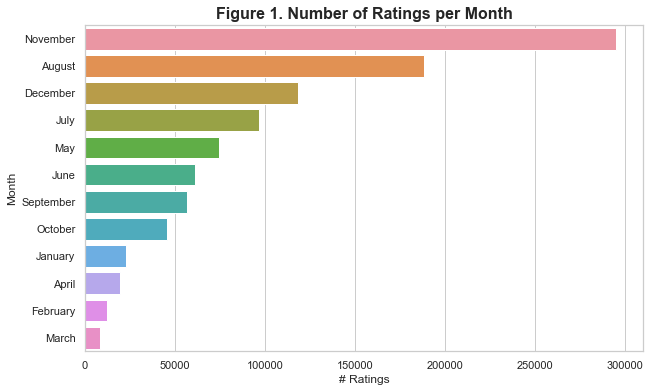

In [9]:
ax = sns.barplot(y=num_rate_per_month.index, x=num_rate_per_month.values)
ax.figure.set_size_inches(10, 6)
ax.set(xlabel='# Ratings', ylabel='Month')
_ = ax.set_title('Figure 1. Number of Ratings per Month', 
                 fontsize=16, fontweight='bold')

As shown in the plot, in **November** and **March** the highest and the lowest number of ratings has been recorded, respectively. It is worth mentioning that the November and December being at the top is correlated with the fact that distributors mostly tend to release their movies in these two months; so, people may watch more movies and therefore more ratings may be done by them in this period, of course this assumes that people rate the movies not long after they watch them which is not always the case. Further, January and Feburary being at the bottom is also correlated with lower rate of movie releases in these two months which make them called as [dump months](https://en.wikipedia.org/wiki/Dump_months). **However, note that these are just correlations and to claim any causality relationship we need to perform a causality analysis between the release date of movies and date of users's ratings, since as you may know, [correlation does not imply causation.](https://en.wikipedia.org/wiki/Correlation_does_not_imply_causation)** 

---

### Q2. What is the average of movie ratings in each month?

**A2.** We can easily group the rows of `ratings` dataframe based on the month value in "Timestap" column and then compute the average of ratings for each group. So, as in previous answer, first we convert "Timestamp" column to `datetime` type using `pd.to_datetime`:

In [10]:
rate_date = pd.to_datetime(ratings['Timestamp'], unit='s')

Then we can use `dt.month_name` method to find the month name of each date and then use `groupby` method to group the values in "Rating" column based on months name and compute the average of each group using `mean` method: 

In [11]:
avg_month_rate = ratings.groupby(rate_date.dt.month_name())['Rating'].mean()

# to sort the result based on the order of the months
# we create an ordered index of months name
month_names = pd.to_datetime(np.arange(1,13), format='%m').month_name()
# and then reorder the result based on order of the months
avg_month_rate = avg_month_rate.reindex(month_names)

Alternatively, you could also use `pd.pivot_table` method to compute the average rating per month. Here is the plot of the result showing the average of ratings in each month:

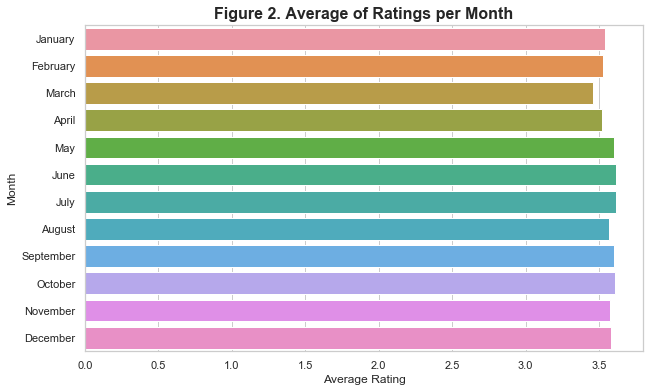

In [12]:
ax = sns.barplot(y=avg_month_rate.index, x=avg_month_rate.values)
ax.figure.set_size_inches(10, 6)
ax.set(xlabel='Average Rating', ylabel='Month')
_ = ax.set_title('Figure 2. Average of Ratings per Month', 
                 fontsize=16, fontweight='bold')

As expected, the average of ratings per month are almost uniform. This is consistent with the intuition that there is no particular reason that average of ratings in a specific month be much higher or lower than that of other months.

---

### Q3. What are the most represented movie genres?

**A3.** To answer this question, we need to use "Genres" column of `movies` dataframe. If you have studied the README file you know that genres in each row are pipe-separated. Let's take a look at the first few rows of `movies` dataframe to confirm this:

In [13]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Therefore, we need to extract the genres for each movie and then count the number of occurences of each genre. For extracting the genres, we can use `str.split` method on the "Genres" column. Since each movie may have one or multiple genres we apply `stack` method on the result of split to basically convert it to a Series object and finally use `value_counts` method to count the number of genres. All of these can be chained in just one line of code:   

In [14]:
genres_count = movies['Genres'].str.split('|', expand=True).stack().value_counts()

The following plot shows the number of movies in each genre:

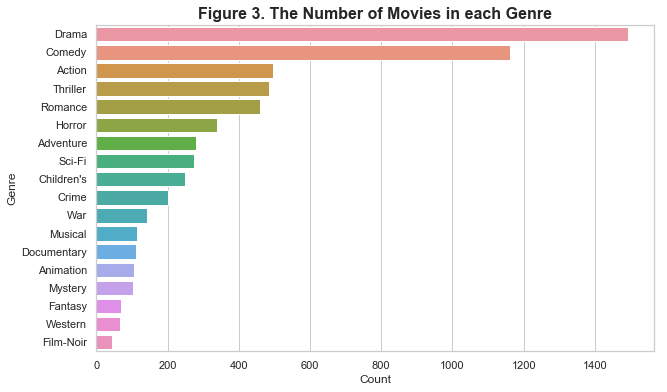

In [15]:
ax = sns.barplot(y=genres_count.index, x=genres_count.values)
ax.figure.set_size_inches(10, 6)
ax.set(xlabel='Count', ylabel='Genre')
_ = ax.set_title('Figure 3. The Number of Movies in each Genre', 
                 fontsize=16, fontweight='bold')

As we can see, **Drama** is the most represented genre in this dataset followed by **Comedy** and **Action**.

---

### Q4. What is the most common pair of genres?

**A4.** We need to find all the genre pairs for each movie and then count the number of their occurences. To achieve this, we first define a lambda function which given a list of genres it would return a list containing all the pairs of genres in the given list using `combinations` method from `itertools` module:

In [16]:
import itertools

comb2 = lambda x: list(itertools.combinations(sorted(x), 2))

As the genres are pipe-separated in "Genres" column in `moives` dataframe, we use `str.split` method to get a list of genres for each movie. Then we apply the function we defined above using `map` method to get a list of all genre pairs for each movie. Next, to be able to get a Series of genre pairs, we create a dataframe from the result of previous step where the genre pairs for each movie is stored in a separate column. Then we can easily use `stack` method on that dataframe to get a Series object which contains all the genre pairs for all the movies. Finally, we apply `value_counts` method to count the number of occurences of each genre pair. All of this can be chained one after another in one line of code:

In [17]:
genre_pairs_count = pd.DataFrame(movies['Genres'].str.split('|').map(comb2).values.tolist())\
                        .stack().value_counts()

Actually, this solution was suggested by Nickil Maveli [in this Stack Overflow answer](https://stackoverflow.com/a/41803183/2099607). Though, we modify that solution a bit and sort each genre list using `sorted` function in the lambda function to avoid duplicate pairs, e.g. `('Drama', 'Comedy')` and `('Comedy', 'Drama')` are the same for our purpose.

Here is the plot showing the top 10 most frequent genre pairs and the number of movies associated with each of them. Note that we don't need to sort the result since the output of `value_counts` method is by default sorted in descending order:

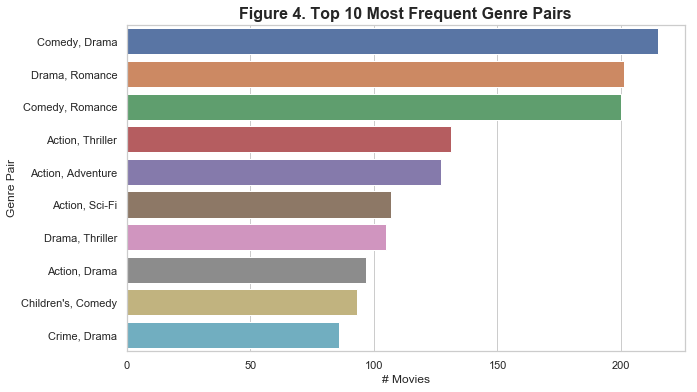

In [18]:
ax = sns.barplot(y=genre_pairs_count.index.str.join(', ')[:10], x=genre_pairs_count.values[:10])
ax.figure.set_size_inches(10, 6)
ax.set(xlabel='# Movies', ylabel='Genre Pair')
_ = ax.set_title('Figure 4. Top 10 Most Frequent Genre Pairs',
                 fontsize=16, fontweight='bold')

As can be seen, all the genre pairs constructed from combination of **Drama**, **Comedy** and **Romance** genres are the most frequent pairs of genres.

---

### Q5. What is the year having the most movies released in that year?

**A5.** If you consult the README file, you would realize that we can find the release year of each movie at the end of its title in "Title" column of `movies` dataframe. Since each movie title has a format of `name (year)`, we can easily use the `str.slice` method to extract the release year (alternatively we can use regex and `str.extract` method) and then use `value_counts` method to count the number of occurences of each year:

In [19]:
movie_year_count = movies['Title'].str.slice(start=-5, stop=-1).value_counts()

The following plot shows the number of movies released in the top 10 years which have the most movie releases:

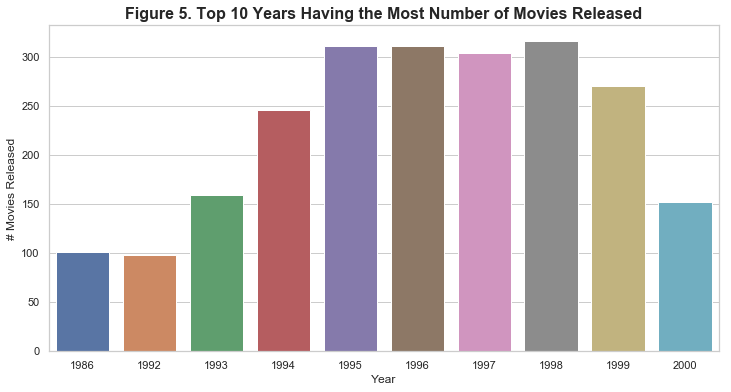

In [20]:
ax = sns.barplot(x=movie_year_count.index[:10], y=movie_year_count.values[:10])
ax.figure.set_size_inches(12, 6)
ax.set(xlabel='Year', ylabel='# Movies Released')
_ = ax.set_title('Figure 5. Top 10 Years Having the Most Number of Movies Released',
                 fontsize=16, fontweight='bold')

As we can see, the **last five years of 20th century** have the most number of movies released, with **1998** being at the very top. Further, note that although the dataset contains the ratings of users from 2000 to 2003, however no movies in the dataset belong to 2001-2003 (we can confirm this by e.g. `assert '2001' not in movie_year_count`).

---

### Q6. Which genres are the most frequent in the top 3 years with the most number of movie releases?

**A6.** We first need to filter out the movies released in the top 3 years which have the most number of movie releases and then find the genres for each movie and count the number of unique genres. Since the entries of "Title" column of `movies` dataframe have the format of `name (year)`, we can find the release year of each movie using `str.slice` method and then use `value_counts` method to find the top 3 years with the most number of movies released:

In [21]:
movie_years = movies['Title'].str.slice(start=-5, stop=-1).rename('Year')
top_years = movie_years.value_counts().nlargest(3).index

Then we filter the movies released in the top years using `isin` method. After that, since the genres in "Genres" column of `movies` dataframe are pipe-separated we need to use `str.split` to find the genres of each movie. Note that we ues `join` to include the release year of movies as a column in the resulting dataframe and then use `set_index` to set it as the index of dataframe:

In [22]:
top_years_genres = movies[movie_years.isin(top_years)]['Genres']\
                    .str.split('|', expand=True).join(movie_years).set_index('Year')

So far we have a dataframe which contains the genres of the movies released in the top years. Now we can use `stack` method to make it a Series object and then easily use `groupby` followed by `size` methods to count the number of movies released for each top year and genre:

In [23]:
top_years_genres_count = top_years_genres.stack().reset_index(name='Genre')\
                            .groupby(['Year', 'Genre']).size().reset_index(name='# Movies')

The following plot shows the result:

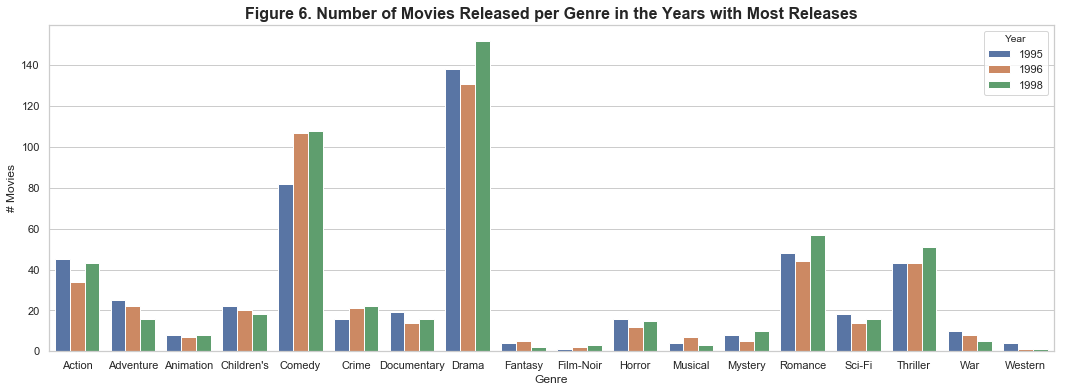

In [24]:
ax = sns.barplot(y='# Movies', x='Genre', hue='Year', data=top_years_genres_count)
ax.figure.set_size_inches(18,6)
_ = ax.set_title('Figure 6. Number of Movies Released per Genre in the Years with Most Releases',
                 fontsize=16, fontweight='bold')

So as shown in the plot, in all the years with most releases **Drama** is the most frequent genre followed by **Comedy** and **Romance**. It's worth mentioning that the frequency of Romance movies is a little higher than Action and Thriller movies in these specific years, wherease overall (i.e. over all the years) it is the otherwise (look at Q3 & A3).

---

### Q7. What is the number of male and female users per each age group?

**A7.** To answer this, we group the values in `users` dataset based on "Gender" and "Age" using `groupby` method and count the number of users in each group using `size` method. If you study the README file, you would realize that the "Age" column does not contain the exact values of users age. Rather, they are encoded as age groups; for example, all the users who are between 18 to 24 years old have been encoded as 18. Therefore to make the result more comprehensible we use `replace` method on "Age" column of the result to replace the encoded values with their actual labels:

In [25]:
gender_per_age_count = users.groupby(['Gender', 'Age']).size().reset_index(name='# Users')

age_groups_labels = {1: '< 18', 18: '18-24', 25: '25-34', 35: '35-44',
                     45: '45-49', 50: '50-55', 56: '56+'}
gender_per_age_count['Age'].replace(to_replace=age_groups_labels, inplace=True)

Instead of using `groupby` directly, you could also use `pd.pivot_table` or `pd.crosstab`. Here is the plot showing the result:

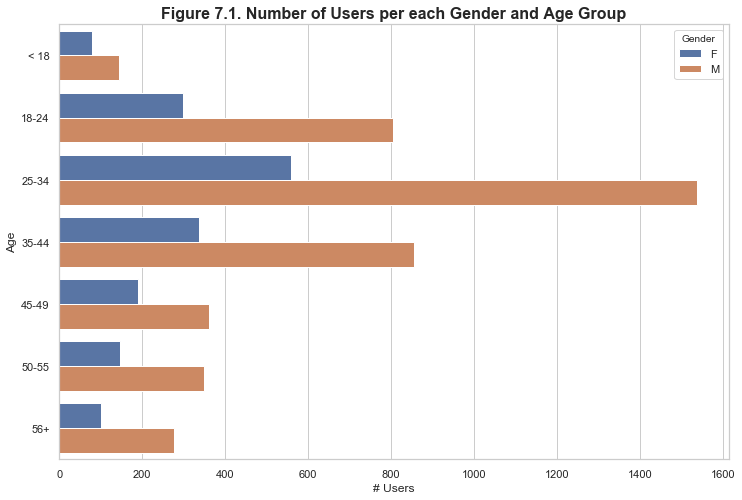

In [26]:
ax = sns.barplot(x='# Users', y='Age', hue='Gender', data=gender_per_age_count)
ax.figure.set_size_inches(12, 8)
_ = ax.set_title('Figure 7.1. Number of Users per each Gender and Age Group',
                 fontsize=16, fontweight='bold')

We can see that the number of male users are almost two times the number of females in all the age groups and the age group "25-34" is the most frequent age group among both male and female users. 

As an extra, we can compare age distribution for male and female users independently. Nothing new needs to be computed since we can use the result of previous step. However, to put the number of males and females in separate columns for each age group and make our work easier for plotting, we just use `set_index` followed by `unstack` methods:

In [27]:
gender_per_age_count_mf = gender_per_age_count.set_index(['Age', 'Gender']).unstack()
# drop the column level (i.e. '# Users') resulted from unstack
gender_per_age_count_mf.columns = gender_per_age_count_mf.columns.droplevel()

Here are the pie charts showing the distribution of age groups:

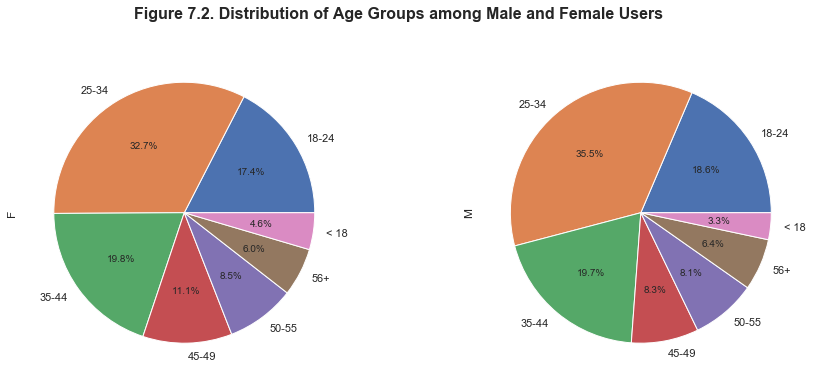

In [28]:
ax = gender_per_age_count_mf.plot.pie(subplots=True, figsize=(15, 6),
                                      legend=False, autopct='%1.1f%%')
_ = ax[0].figure.suptitle('Figure 7.2. Distribution of Age Groups among Male and Female Users',
                          fontsize=16, fontweight='bold')

As we can see, the distribution of male and female users are almost the same over the age groups. However, it must be noted that a rather noticable difference (> 2%) is observed in "25-34" and "45-49" age groups between male and females compared to other age groups.

---

### Q8. What is the number of male and female users in each occupation?

**A8.** We can answer this question by grouping based on "Gender" and "Occupation" columns of `users` dataframe and use `size` method to count the number of users in each group. The values for occupations are integer-encoded and the corresponding labels for values have been provided in the README file. So we use `replace` method on the result to convert the encoded values to a comprehensible format:

In [29]:
occupation_per_gender_count = users.groupby(['Occupation', 'Gender']).size()\
                                .reset_index(name='# Users')

occupation_labels = {0: "other or not specified", 1: "academic/educator",
                     2: "artist", 3: "clerical/admin", 4: "college/grad student",
                     5: "customer service", 6: "doctor/health care",
                     7: "executive/managerial", 8: "farmer", 9: "homemaker",
                     10: "K-12 student", 11: "lawyer", 12: "programmer",
                     13: "retired", 14: "sales/marketing", 15: "scientist",
                     16: "self-employed", 17: "technician/engineer",
                     18: "tradesman/craftsman", 19: "unemployed", 20: "writer"}

occupation_per_gender_count['Occupation'].replace(to_replace=occupation_labels, inplace=True)

Again, `pd.pivot_table` and `pd.crosstab` could also be used here instead. The following plot shows the result:

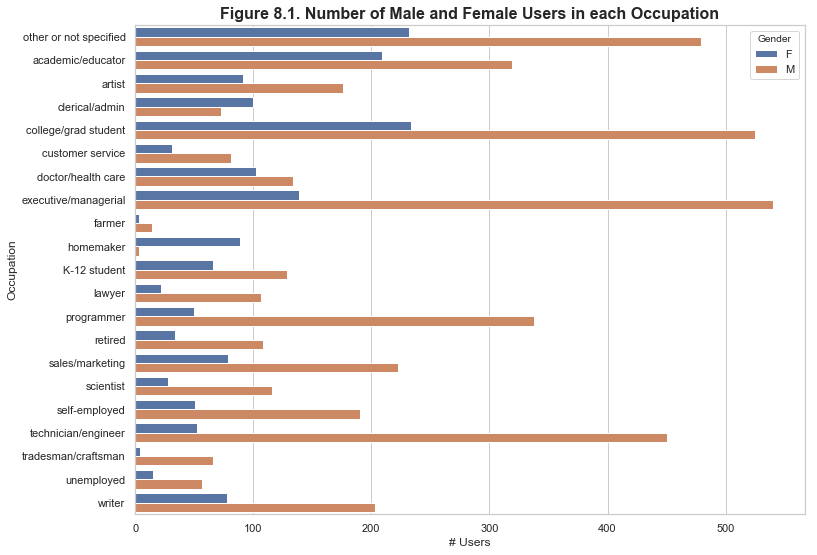

In [30]:
ax = sns.barplot(y='Occupation', x='# Users', hue='Gender', data=occupation_per_gender_count)
ax.figure.set_size_inches(12, 9)
_ = ax.set_title('Figure 8.1. Number of Male and Female Users in each Occupation', 
                 fontsize=16, fontweight='bold')

It is interesting that among **male** users those with **executive or managerial** roles are the most represented group, whereas among **female** users the **college or graduate students** are the most represented group. Further, for each occupation the number of males is greater than females except for the **homemaker** and **clerical/administrative** groups where female users are more represented. 

We can also plot the distribution of occupations for male and female users independently. We take the result of previous step and use `set_index` followed by `unstack` methods to put males and females counts in separate columns. Then we normalize each column by dividing them by their sum:

In [31]:
occupation_per_gender_count_mf = occupation_per_gender_count.set_index(['Occupation', 'Gender']).unstack()
# drop the column level resulted from unstack method
occupation_per_gender_count_mf.columns = occupation_per_gender_count_mf.columns.droplevel()
occupation_per_gender_count_mf /= occupation_per_gender_count_mf.sum()
occupation_per_gender_count_mf.sort_values(by='F', ascending=False, inplace=True)

The pie charts might be the default choice for plotting such a categorical distribution, however we use bar plot instead since the number of different occupations is large and therefore pie charts would not be visually plausible in this case:

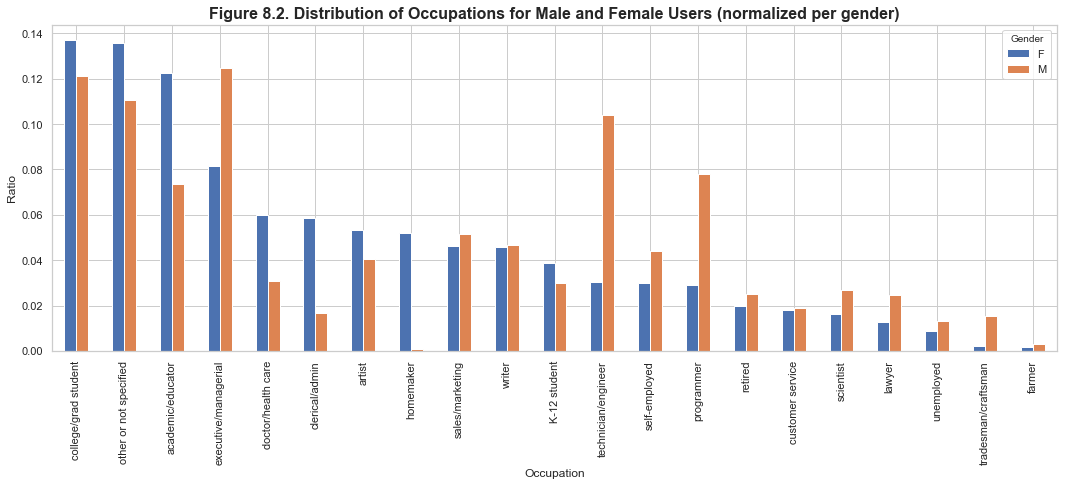

In [32]:
ax = occupation_per_gender_count_mf.plot.bar(subplots=False, figsize=(18, 6))
ax.set_title('Figure 8.2. Distribution of Occupations for Male and Female Users (normalized per gender)',
             fontsize=16, fontweight='bold')
_ = ax.set_ylabel('Ratio')

Unlike the distributions of age groups among male and female users (look Q7 & A7), the distributions of occupations among them are **not similar** to each other in this dataset. Further, as an example, although the **number of men** who work in **health-care** sector is **greater** than the **number of women** working in the same sector (look at Plot 8.1), however this **does not hold proportionally**. We can see that a **higher porportion of women** work in health-care sector than **men**. We can easily observe that the same thing applies to other occupations such as **college or graduate students**, **academics or educators**, **artists** and **K-12 students** by comparing this plot with the previous plot.

---

So far the questions could be answered by just analyzing the data contained in only one of the dataframes. Now, let's ask some questions which in order to answer them, we need the information from two or more dataframes.

### Q9. How many users and ratings are there per gender?

**A9.** To find the number of users per gender we only need to use the `users` dataframe and perform a `groupby` operation on "Gender" column. However, to find the number of ratings per gender we need to merge `ratings` and `users` dataframes using `merge` method and then use `groupby` method on the "Gender" column of merged dataframe:

In [33]:
users_gender_count = users.groupby('Gender').size().rename('# Users')
ratings_gender_count = ratings[['UserID']].merge(users[['UserID', 'Gender']])\
                            .groupby('Gender').size().rename('# Ratings')

Note that we only selected the necessary columns, namely "UserID" column from `ratings` dataframe and "UserID" and "Gender" from `users` dataframe, before performing the merge operation. Finally, we use `pd.concat` method to concatenate the resulting dataframes into one dataframe which contains all we needed: 

In [34]:
gender_count = pd.concat([users_gender_count, ratings_gender_count], axis=1).reset_index()

Alternatively, you could also merge `ratings` and `users` dataframes and use `pd.pivot_table` on the result to compute both the number of ratings and the number of users per gender at once:

In [35]:
_ = ratings.merge(users).pivot_table(index='Gender', values=['Rating', 'UserID'],
                                     aggfunc={'Rating': 'size', 'UserID': 'nunique'})

Here is the plot showing the results, one subplot showing the number of users and another showing the number of ratings per gender:  

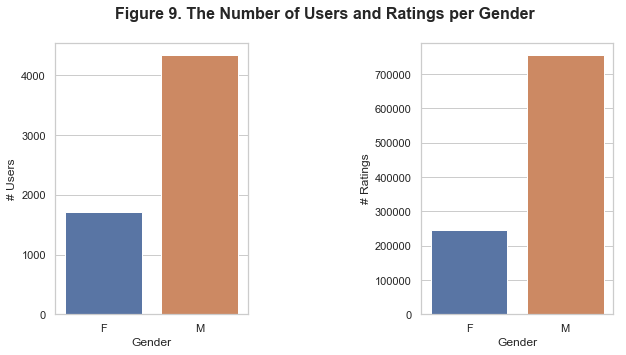

In [36]:
fig, ax = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.9)
fig.set_size_inches(10, 5)
fig.suptitle('Figure 9. The Number of Users and Ratings per Gender', 
             fontsize=16, fontweight='bold')
sns.barplot(y='# Users', x='Gender', data=gender_count, ax=ax[0])
_ = sns.barplot(y='# Ratings', x='Gender', data=gender_count, ax=ax[1])

The number of male users is more than two times the number of female users in this dataset. Also the number of ratings done by male users is almost three times the number of women's.

---

### Q10. Which movies have the highest average ratings?

**A10.** We can easily find the average rating of each movie using `ratings` dataframe, however in order to find the names of the movies we need to merge the result with `movies` dataframe. For getting a more reliable average rating we only consider those movies which at least 25 users have rated them. To find them, we use `groupby` method on "MovieID" column of `ratings` dataframe and then use `transform` method to count the number of ratings for each movie:

In [37]:
ratings_25 = ratings[ratings.groupby('MovieID')['MovieID'].transform('count') >= 25]

Next, we first find the average rating of each movie and then merge the result with `movies` dataframe to find the title of movies. Finally, we select the highest rated movies using `nlargest` method: 

In [38]:
avg_rating = movies.merge(ratings_25.groupby('MovieID')['Rating'].mean()\
                          .reset_index(name='Avg Rating'), on='MovieID')

top_movies = avg_rating.nlargest(20, columns=['Avg Rating'])

Here is the plot showing the top 20 movies along with their average ratings:

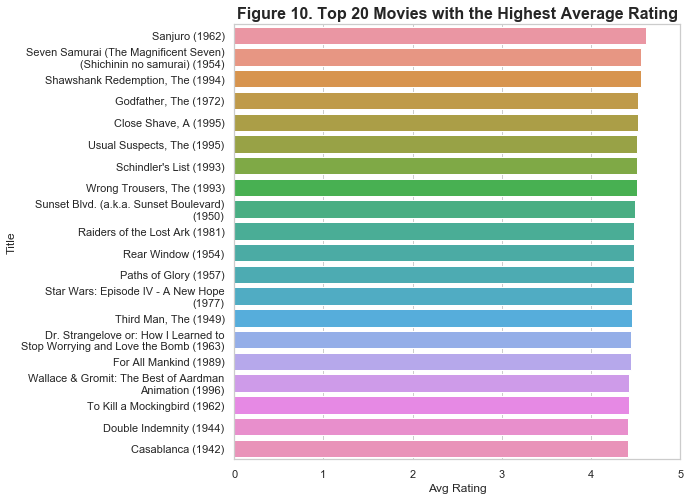

In [39]:
top_movies['Title'] = top_movies['Title'].str.wrap(40)
ax = sns.barplot(x='Avg Rating', y='Title', data=top_movies)
ax.figure.set_size_inches(8, 8)
ax.set_xticks(np.arange(0,6))
_ = ax.set_title('Figure 10. Top 20 Movies with the Highest Average Rating',
                 fontsize=16, fontweight='bold')

There is nothing much to say about this plot, except that it's interesting that I haven't watched most of them yet! So I can't comment on the rationality of the users' ratings!!! (Just kidding!)

---

### Q11. What is the average rating of movies per genre?

**A11.** As before, we first find the genres of each movie in the `movies` dataframe using `str.split` method and then merge the result with `ratings` dataframe:

In [40]:
movie_genres = movies.set_index('MovieID')['Genres'].str.split('|', expand=True)\
                    .stack().reset_index(level=1, drop=True).rename('Genre')
ratings_with_genres = ratings[['MovieID', 'Rating']].merge(movie_genres.to_frame(),
                                                           left_on='MovieID',
                                                           right_index=True)

Then we just need to use `groupby` method on "Genre" column and compute the average of "Rating" column for each genre:

In [41]:
genres_avg_ratings = ratings_with_genres.groupby('Genre')['Rating']\
                        .mean().sort_values(ascending=False)

Here is the plot of genre ratings sorted in descending order from top to bottom:

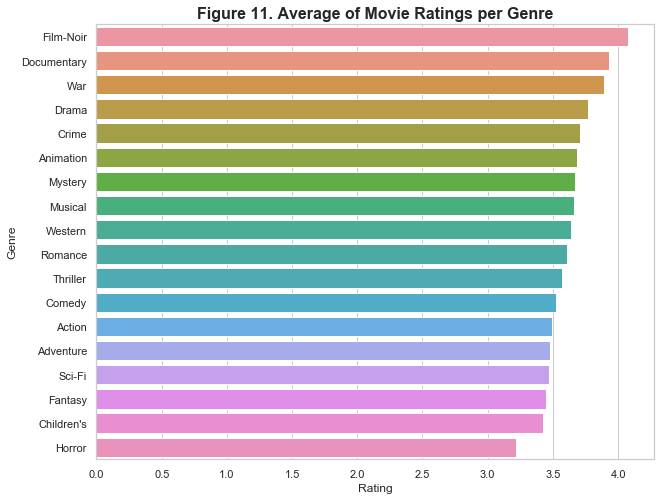

In [42]:
ax = sns.barplot(y=genres_avg_ratings.index, x=genres_avg_ratings)
ax.figure.set_size_inches(10, 8)
_ = ax.set_title('Figure 11. Average of Movie Ratings per Genre',
                 fontsize=16, fontweight='bold')

**Film-Noir**, **Documentary** and **War** are the genres with the highest average rating, whereas **Horror**, **Children's** and **Fantasy** are at the bottom. Although, it must be noted that all the top 3 genres with the highest average rating have a much smaller number of movies associated with them compared to an also high-ranking genre like **Drama** (look Q3 & A3). As a side note, it is not clear that **Horror** movies being rated lower on average, is the result of them being too scary or rather not being scary at all as much as they claimed!

---

### Q12. What are the top 3 movies with the highest average rating in each genre?

**A12.** We first find the genres of each movie in `movies` dataframe by applying `str.split` on the entries in "Genres" column:

In [43]:
movie_genres = movies.set_index('MovieID')['Genres'].str.split('|', expand=True)\
                    .stack().reset_index(level=1, drop=True).rename('Genre')

Then we merge the result with `ratings` dataframe to have the movie ratings and the genres alongside each other in one dataframe. Note that, as before, we first exclude those movies with less than 25 ratings using the combination of `groupby` and `transform` methods:

In [44]:
ratings_25 = ratings[ratings.groupby('MovieID')['MovieID'].transform('count') >= 25]
ratings_with_genres = ratings_25[['MovieID','Rating']].merge(movie_genres.to_frame(),
                                                             right_index=True,
                                                             left_on='MovieID')

Next, we find the top 3 movies with the highest average rating in each genre by first using `groupby` on "Genre" column and then utilizing `apply` to compute the average rating of each movie in each of its related genres and select the top 3 movies. Finally, we merge the result with `movies` dataframe using `merge` method to find the title of each movie:

In [45]:
top3_per_genre = ratings_with_genres.groupby('Genre')\
                    .apply(lambda x: x.groupby('MovieID').mean().nlargest(3, 'Rating'))\
                    .reset_index().merge(movies[['Title', 'MovieID']], on='MovieID')

Here is a big plot showing the top 3 movies in each genre along with their average rating:

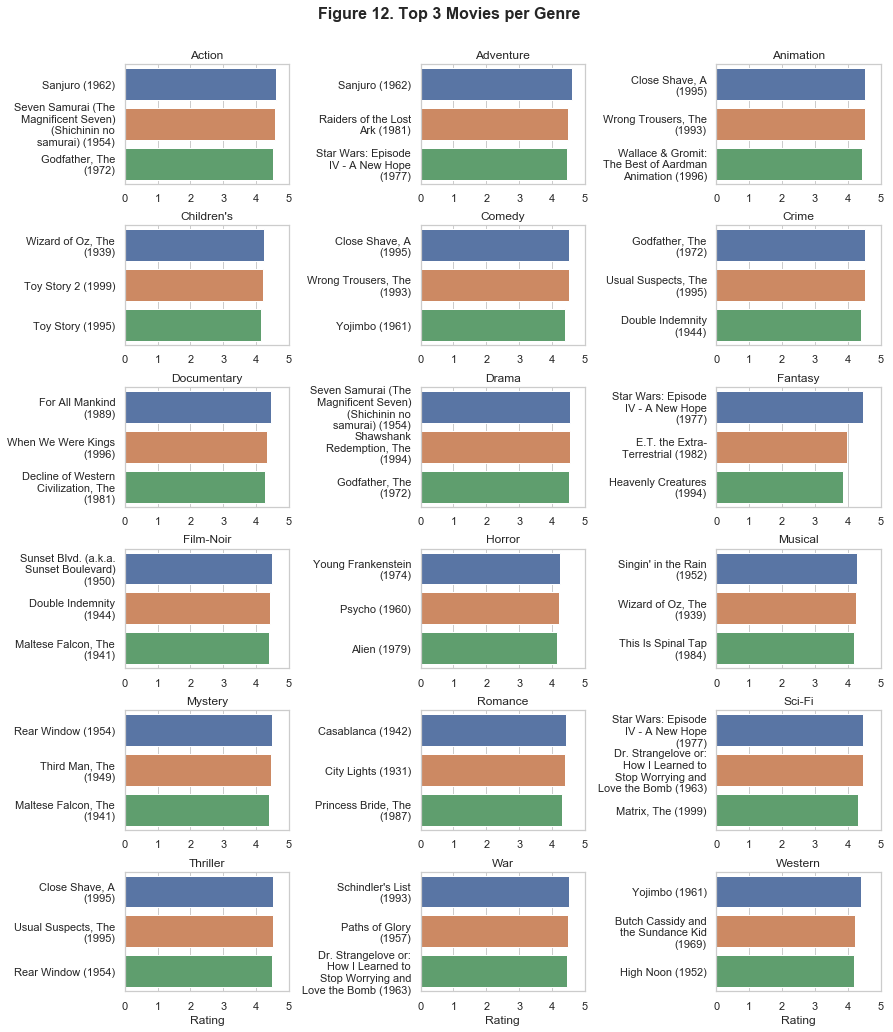

In [46]:
n_rows, n_cols = 6, 3
top3_per_genre['Title'] = top3_per_genre['Title'].str.wrap(20)
top3_per_genre.sort_values(['Genre', 'Rating'], ascending=[True,False], inplace=True)
genres = top3_per_genre['Genre'].unique()
fig, ax = plt.subplots(n_rows, n_cols)
fig.set_size_inches(12, 16)
fig.suptitle('Figure 12. Top 3 Movies per Genre', fontsize=16, fontweight='bold')
fig.subplots_adjust(wspace=0.8, top=0.93, right=1., hspace=0.35)
for i in range(n_rows):
    for j in range(n_cols):
        data = top3_per_genre[top3_per_genre.Genre == genres[i*n_cols+j]]
        sns.barplot(x='Rating', y='Title', data=data, ax=ax[i,j])
        ax[i,j].set(title=genres[i*n_cols+j], ylabel=None)
        if i != n_rows -1:
            ax[i,j].set_xlabel(None)
        ax[i,j].set_xticks(np.arange(0,6))

These plots give a better understanding of top movies. For example, **Casablanca (1942)** is at the bottom of the list of top 20 movies with the highest average rating (see Q&A10); however, it is the top movie in the **Romance** genre as shown above. As another examples, we can observe that **Singin' in the Rain (1952)**, **Young Frankenstein (1974)**, **Pyscho (1960)** and **The Wizard of Oz (1939)** are not in the list of top 20 movies at all, however as shown in the previous plot, they are one of the top 3 movies in their respective genres. For instance, this point is especially relevant when designing a **movie recommender system**, where a considerable porpotion of its users are mostly interested in only a few genres and therefore generating recommendations only based on statistics computed over all the dataset (rather than over subgroups or clusters) may not be suitable or accurate at all.

---

### Q13. What are the top movies with the highest average rating among male and female users?

**A13.** To answer this we need to use all the dataframes: `ratings` dataframe to get the ratings, `movies` dataframe to get the title of movies and `users` dataframe to get the gender of users. As before, to get a more reliable list of top movies, we filter out those movies with less than 25 ratings among male and female users **independently**. Therefore, we first merge the `ratings` dataset with `users` dataset to find the gender of the users for each rating. Then exclude the movies with low number of ratings per male and female users independently by using `groupby` and `transform` methods:

In [47]:
ratings_with_gender = ratings[['UserID', 'MovieID', 'Rating']]\
                        .merge(users[['UserID', 'Gender']], on='UserID').drop(columns='UserID')
ratings25_with_gender = ratings_with_gender[ratings_with_gender
                                             .groupby(['Gender', 'MovieID'])['MovieID']
                                             .transform('count') >= 25]

Now we compute the average rating of movies among male and female users independently using `groupby` method on "Gender" column and utilizing `apply` method with another `groupby` on "MovieID" column. Finally we merge the result with `movies` dataframe to find the title of the movies:

In [48]:
top_rating_gender = ratings25_with_gender.groupby('Gender')\
                        .apply(lambda x: x.groupby('MovieID').mean().nlargest(20, 'Rating'))\
                        .reset_index().merge(movies[['MovieID','Title']], on='MovieID')

Here is the plot showing the top 20 movies among male and female viewers:

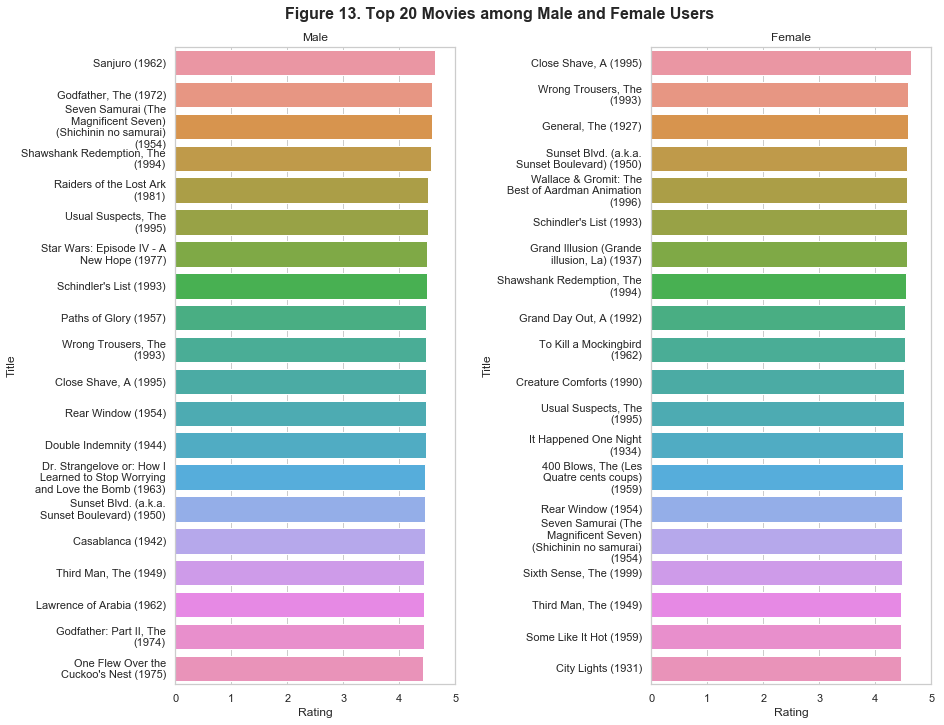

In [49]:
top_rating_gender['Title'] = top_rating_gender['Title'].str.wrap(25)
top_rating_gender.sort_values(['Rating', 'Title'], ascending=[False, True], inplace=True)
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 11)
fig.suptitle('Figure 13. Top 20 Movies among Male and Female Users',
             fontsize=16, fontweight='bold')
fig.subplots_adjust(wspace=0.7, top=0.93, right=1., hspace=0.35)

data = top_rating_gender[top_rating_gender['Gender'] == 'M']
sns.barplot(x='Rating', y='Title', data=data, ax=ax[0])
ax[0].set_title('Male')
ax[0].set_xticks(np.arange(0,6))

data = top_rating_gender[top_rating_gender['Gender'] == 'F']
sns.barplot(x='Rating', y='Title', data=data, ax=ax[1])
ax[1].set_title('Female')
_ = ax[1].set_xticks(np.arange(0,6))

As you can see there are differences between the list of favorite movies among male and female viewers. Of course, they share some of the movies as their most favorites though with different order in the list:

In [50]:
top_rating_gender[top_rating_gender.duplicated(subset='MovieID')]['Title']\
                    .reset_index(level=0, drop=True)

0                    Shawshank Redemption, The\n(1994)
1                          Usual Suspects, The\n(1995)
2                              Schindler's List (1993)
3    Seven Samurai (The\nMagnificent Seven)\n(Shich...
4                          Wrong Trousers, The\n(1993)
5                                Close Shave, A (1995)
6                                   Rear Window (1954)
7       Sunset Blvd. (a.k.a.\nSunset Boulevard) (1950)
8                                Third Man, The (1949)
Name: Title, dtype: object

If you compare these lists with the list of overall top movies (see Q&A10), you realize that most of the top movies among male viewers are also among the top movies overall; however, this is not the case for female users. This is expected since the number of male users and the number of ratings they have done are much higher than female users and their number of ratings (see Q&A9), so the list of overall top movies is heavily influenced by the men's tastes.

---

### Q14. Which movies are liked by female users much more than male users?

**A14.** To answer this we need to find the movies for which the difference of their average ratings by female and male users is the highest. So it is similar to the previous answer (i.e. A13) except that after finding the avarage rating of each movie among male and female users independently, we compute the difference and take the largest ones:

In [51]:
ratings_with_gender = ratings[['UserID', 'MovieID', 'Rating']]\
                        .merge(users[['UserID', 'Gender']], on='UserID')
# filter out movies with less than 25 ratings per gender
ratings25_with_gender = ratings_with_gender[ratings_with_gender\
                                            .groupby(['Gender', 'MovieID'])['MovieID']\
                                            .transform('size') >= 25]
highest_fm_diff = ratings25_with_gender.groupby(['MovieID','Gender'])['Rating'].mean().unstack(1)\
                        .assign(Diff= lambda x: x['F'] - x['M']).nlargest(10, 'Diff').reset_index()\
                        .merge(movies[['MovieID', 'Title']], on='MovieID')

Note that in this answer, unlike the previous answer, we did not use `apply` method. Rather, we used `groupby` on both "MovieID" and "Gender" columns since we wanted to find average ratings for **all the movies** per gender (and not only selecting the top ones). Then we computed the ratings difference and selected the top 10 movies with the highest difference.

The following plot shows the movies which are liked by female viewers much more than males viewers, along with their ratings among males and females as well as the difference of ratings:

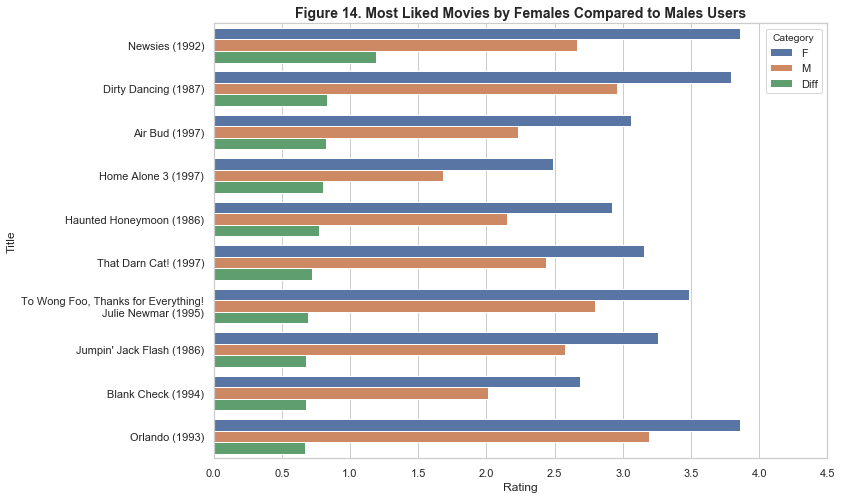

In [52]:
data = highest_fm_diff.melt(id_vars=['Title'], value_vars=['F', 'M', 'Diff'],
                            value_name='Rating', var_name='Category')
data['Title'] = data['Title'].str.wrap(35)

ax = sns.barplot(x='Rating', y='Title', hue='Category', data=data)
ax.figure.set_size_inches(11, 8)
ax.set_title('Figure 14. Most Liked Movies by Females Compared to Males Users',
             fontsize=14, fontweight='bold')
_ = ax.set_xticks(np.arange(0,5.0, 0.5))

Except for **Newsies (1992)**, the difference of ratings between female and male viewers for all the movies is less than one. Further, all of them has a difference of greater than 0.5. So one simple conclusion might be that although there are movies that female users like more than males, however at least in this dataset, it is not the case that the difference to be so significant (> 1).

---

### Q15. Which movie genres are more liked by men and women?

**A15.** As the previous answers to the questions which involved genre information, we first need to extract genre information for each movie using `str.split` method:

In [53]:
movie_genres = movies.set_index('MovieID')['Genres'].str.split('|', expand=True)\
                .stack().reset_index(level=1, drop=True).rename('Genre').reset_index()

Then we merge the result with `ratings` and `users` dataframe to include both gender and genre information of users and movies along with ratings information in one dataframe. Then we simply compute the average rating of movies per both genre and gender using `groupby` and `mean` methods:

In [54]:
ratings_gg = ratings[['MovieID', 'UserID', 'Rating']].merge(movie_genres, on='MovieID')\
                    .merge(users[['UserID', 'Gender']], on='UserID')
avg_ratings_gg = ratings_gg.groupby(['Genre', 'Gender'])['Rating'].mean().reset_index()

The following figure shows the average ratings per genre and gender:

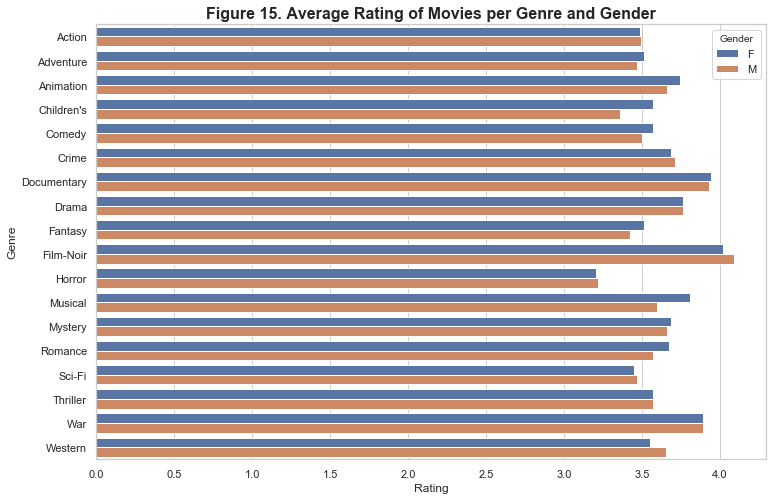

In [55]:
ax = sns.barplot(x='Rating', y='Genre', hue='Gender', data=avg_ratings_gg)
ax.figure.set_size_inches(12, 8)
_ = ax.set_title('Figure 15. Average Rating of Movies per Genre and Gender',
                 fontsize=16, fontweight='bold')

As we can see, the average ratings in each genre are very close to each other for male and female users. Though, there is a rather noticable difference in **Children's**, **Musical** and **Romance** genres where compared to other genres the average of ratings given by females is higher than males. Further, the genres with the highest average rating are **Film-Noir**, **Documentary** and **War** among both males and females, which are also the top genres overall (see Q&A11).

---

### Q16. What are the movies with most mixed reactions?

**A16.** The "most mixed reactions" means that different users may have completely different opinions about them. Obvisously, the opinions of users about the movies are encoded as the ratings they have given to the movies and we can measure the variations in the ratings using standard deviation. Those movies with the highest standard devation in their ratings are considered as the movies with the most mixed reactions. For this, we first filter out movies with less than 100 ratings to consider only the movies which have gained enough attention:

In [56]:
ratings_100 = ratings[ratings.groupby('MovieID')['MovieID'].transform('count') >= 100]

Then we find the standard deviation of the ratings for each movie using `groupby` and `std` methods and then select the top 10 movies with the highest ratings standard deviation. Finally, we merge the result with `movies` dataframe to find the title of each movie:

In [57]:
mixed_react = ratings_100.groupby('MovieID')['Rating'].std().nlargest(10).rename('Rating Std')\
                .to_frame().merge(movies[['MovieID', 'Title']], left_index=True, right_on='MovieID')

We have found the movies with highest mixed reactions. However, to better demonstrate the high variation of ratings for these movies, we gather all their ratings in a dataframe and use a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) to show the distribution of ratings:

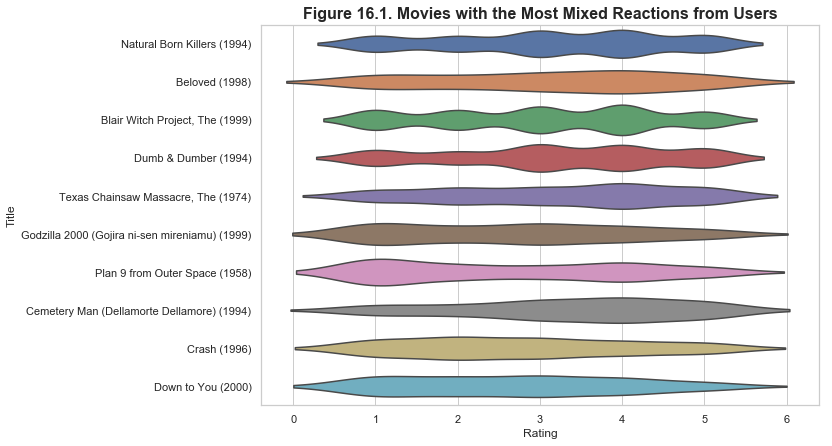

In [58]:
mixed_react_rating = ratings_100[ratings_100['MovieID'].isin(mixed_react['MovieID'])]\
                        .merge(movies[['MovieID', 'Title']], on='MovieID')

# plot the results using a violin plot
ax = sns.violinplot(x='Rating', y='Title', data=mixed_react_rating, inner=None)
ax.figure.set_size_inches(10, 7)
_ = ax.set_title('Figure 16.1. Movies with the Most Mixed Reactions from Users',
                 fontsize=16, fontweight='bold')

The movies shown in the plot above are the movies with the most mixed reactions from viewers. As you can see in the plot above, the distribution of ratings is spread across all the ratings levels (1 to 5) for all of these movies. To better understand this fact, compare it with the following plot which shows the distribution of ratings for the movies with the most unanimous reactions from users. Here, similar to the previous step we compute standard deviation of ratings for each movie, but we select the movies with the smallest standard deviation:

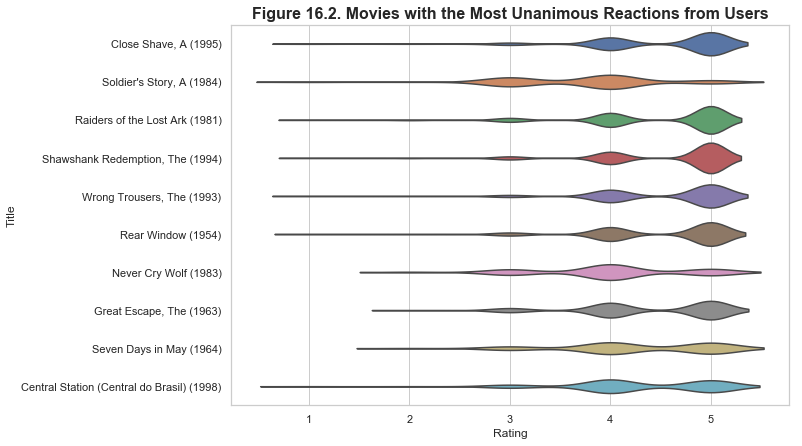

In [59]:
unan_react = ratings_100.groupby('MovieID')['Rating'].std().nsmallest(10).rename('Rating Std')\
                .to_frame().merge(movies[['MovieID', 'Title']], left_index=True, right_on='MovieID')
unan_react_rating = ratings_100[ratings_100.MovieID.isin(unan_react.MovieID)]\
                        .merge(movies[['MovieID', 'Title']], on='MovieID')
                        
# plot the result using violin plot
ax = sns.violinplot(x='Rating', y='Title', data=unan_react_rating,inner=None)
ax.figure.set_size_inches(10, 7)
_ = ax.set_title('Figure 16.2. Movies with the Most Unanimous Reactions from Users',
                 fontsize=16, fontweight='bold')

These are the movies with the most unanimous reactions from users. As you can see these movies have mostly receieved ratings of 4 or 5 which in turn make them have a small standard deviation for their ratings. In other words, that means most of the users are in a general agreement regarding their opinions about these movies (which for these specific movies, they have a very positive opinion about them).

---

### Q17. What are the highest rated movies in each age group?

**A17.** To compute the average rating of the movies for each age group, we first merge the `ratings` dataset with `users` dataset to have age information along with ratings in one dataframe. Then we exclude those movies with less than 25 ratings for each age group using `groupby` on "Age" and "MovieID" columns along with `transform` method:

In [60]:
ratings_age = ratings[['MovieID', 'UserID', 'Rating']]\
                    .merge(users[['UserID', 'Age']], on='UserID')
ratings25_age = ratings_age[ratings_age.groupby(['Age', 'MovieID'])['MovieID']\
                            .transform('count') >= 25]

After filtering the movies, we use `groupby` method on "Age" column and utlilize `apply` method to compute the average rating of each movie in each age group. Finally, we merge the result with `movies` dataframe to find the title of each movie. Further, since the age groups are stored in encoded form, we use `map` method on "Age" column to convert them to a comprehensible format:

In [61]:
avg_rating_per_age = ratings25_age.groupby('Age')\
                        .apply(lambda x: x.groupby('MovieID')['Rating'].mean().nlargest(5))\
                        .reset_index().merge(movies[['MovieID', 'Title']], on='MovieID')

age_groups_labels = {1: '< 18', 18: '18-24', 25: '25-34', 
                     35: '35-44', 45: '45-49', 50: '50-55', 56: '56+'}
avg_rating_per_age['Age'] = avg_rating_per_age['Age'].map(age_groups_labels)

The following plot shows the top 5 favorite movies for each age group along with their ratings:

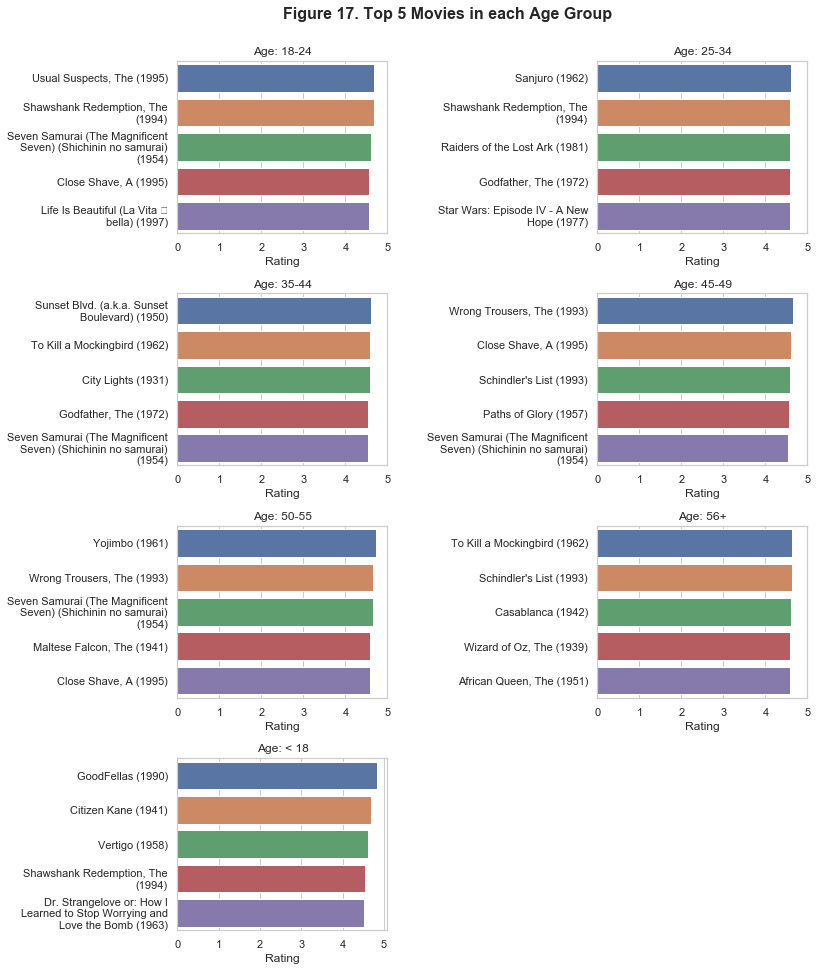

In [62]:
data = avg_rating_per_age.assign(Title= lambda x: x['Title'].str.wrap(30))
data = data.sort_values(['Age', 'Rating'], ascending=[True, False])

age_groups = data.Age.unique()
n_rows, n_cols = 4, 2
fig, ax = plt.subplots(n_rows,n_cols)
fig.delaxes(ax[n_rows-1, n_cols-1])
fig.set_size_inches(10, 15)
fig.subplots_adjust(wspace=1, top=0.93, right=1., hspace=0.35)
fig.suptitle('Figure 17. Top 5 Movies in each Age Group', 
             fontsize=16, fontweight='bold')
for i in range(n_rows):
    for j in range(n_cols):
        if i == n_rows-1  and j == n_cols - 1:
            break
        dt = data[data['Age'] == age_groups[i*n_cols+j]]
        sns.barplot(x='Rating', y='Title', data=dt, ax=ax[i,j])
        ax[i,j].set(title='Age: ' + age_groups[i*n_cols+j], ylabel=None)
        ax[i,j].set_xticks(np.arange(0,6))

One thing to note is that in all the age groups, the top 5 movies belong to multiple different genres. Further, it is not the case that in an age group all the top movies be very recent (i.e. released after 1990, considering the date that dataset was collected) or all of them be very old movies (i.e. released before 1970); rather, in each age group, both recent and old movies exist as the top movies. In other words, we cannot say that all of the top movies of a certain age group belong to a specific genre or a specific period of time.  

---

### Q18. What are the favorite movies among college/graduate students?

**A18.** We need to compute the average rating of each movie among college/graduate students and select the top ones. For that, we first find the college/graduate students in `users` dataframe and then find their given movie ratings and compute the average of ratings for each movie using `groupby` method on "MovieID" column. As usual, we merge the result with `movies` dataframe to find the title of movies. Further, note that before computing the average rating, we exclude the movies which have received less than 25 ratings from college/graduate students:

In [63]:
# the occupation code for college/graduate students is 4
stu_ids = users[users['Occupation'] == 4]['UserID']
stu_ratings = ratings[ratings['UserID'].isin(stu_ids)]
stu_ratings25 = stu_ratings[stu_ratings.groupby('MovieID')['MovieID'].transform('count') >= 25]
top_stu_avg_ratings = stu_ratings25.groupby('MovieID')['Rating'].mean().reset_index()\
                        .merge(movies[['MovieID', 'Title']], on='MovieID').nlargest(10, 'Rating')

Here is the plot showing the top 10 favorite movies among college/graduate students along with their average ratings:

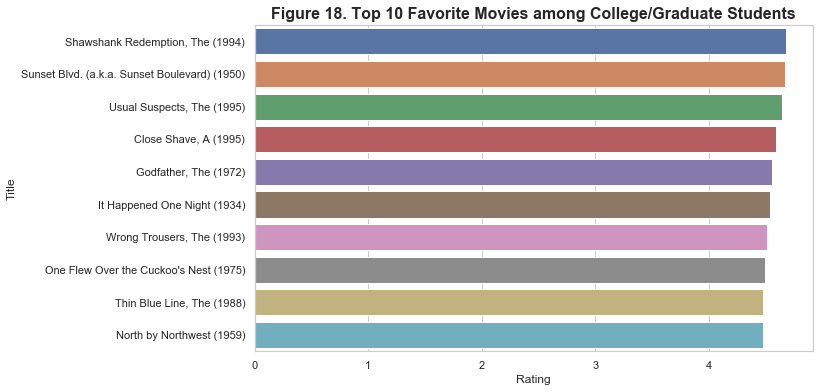

In [64]:
ax = sns.barplot(x='Rating', y='Title', data=top_stu_avg_ratings)
ax.figure.set_size_inches(10, 6)
_ = ax.set_title('Figure 18. Top 10 Favorite Movies among College/Graduate Students',
                 fontsize=16, fontweight='bold')

It is interesting that out of these 10 movies four of them, namely **It Happened One Night (1934)**, **One Flew Over the Cuckoo's Nest (1975)**, **The Thin Blue Line (1998)** and **North by Northwest (1959)** are not among the overall top 20 movies (see Q&A10). Further, **The Thin Blue Line (1998)** and **North by Northwest (1959)** are not in the lists of top 20 movies among male and female viewers. So one might conclude that these two movies are especially liked by the college/graduate students which may not be the case for other users in other occupations.

---

I hope you have enjoyed reading this data analysis tutorial and it has helped you to better understand the pandas methods and functionalities.